In [1]:
import gymnasium as gym
import numpy as np
import associata

import matplotlib.pyplot as plt
%matplotlib inline

from rl import *

# Gymnasium

## Lunar lander

In [2]:
env = gym.make("LunarLander-v2", render_mode="human")
observation, info = env.reset(seed=42)

for _ in range(1):
    action = env.action_space.sample()
    observation, reward, terminated, truncated, info = env.step(action)

    if terminated or truncated:
        observation, info = env.reset()

env.close()

## Cart pole

In [3]:
state_space_bounds = np.array([[-2.5, -3.0, -0.25, -3.0], [2.5, 3.0, 0.25, 3.0]])
# state_space_epsilon = np.array([0.5, 0.5, 0.05, 0.5])
state_space_epsilon = np.array([0.1, 0.1, 0.01, 0.1])
state_space_feature_names = ['x_pos', 'x_speed', 'ang_pos', 'ang_speed']
action_space = np.array([0, 1])

### Sarsa

In [4]:
sarsa = Sarsa(state_space_bounds, state_space_epsilon, action_space)

In [19]:
sarsa.alpha = 0.25

In [20]:
env = gym.make("CartPole-v1", render_mode="rgb_array")
observation, info = env.reset()

reward = None

# min_obs = observation
# max_obs = observation

for _ in range(2000):
    action = sarsa.step(observation, reward)[0]
    observation, reward, terminated, truncated, info = env.step(action)

    # min_obs = np.min(np.array([observation, min_obs]), axis=0)
    # max_obs = np.max(np.array([observation, max_obs]), axis=0)

    if terminated or truncated:
        observation, info = env.reset()
        sarsa.reset_episode()
        reward = None

sarsa.reset_episode(False)
env.close()


=============== Step 0 ===============
[14s] Picked action: [1]

=============== Step 1 ===============
[14s] Picked action: [0]

=============== Step 2 ===============
[14s] Picked action: [1]

=============== Step 3 ===============
[14s] Picked action: [0]

=============== Step 4 ===============
[14s] Picked action: [1]

=============== Step 5 ===============
[14s] Picked action: [0]

=============== Step 6 ===============
[14s] Picked action: [1]

=============== Step 7 ===============
[14s] Picked action: [1]

=============== Step 8 ===============
[14s] Picked action: [1]

=============== Step 9 ===============
[14s] Picked action: [1]

=============== Step 10 ===============
[14s] Picked action: [1]

=============== Step 11 ===============
[14s] Picked action: [0]

=============== Step 12 ===============
[14s] Picked action: [0]

=============== Step 13 ===============
[14s] Picked action: [0]

=============== Step 14 ===============
[14s] Picked action: [1]

=============== Ste

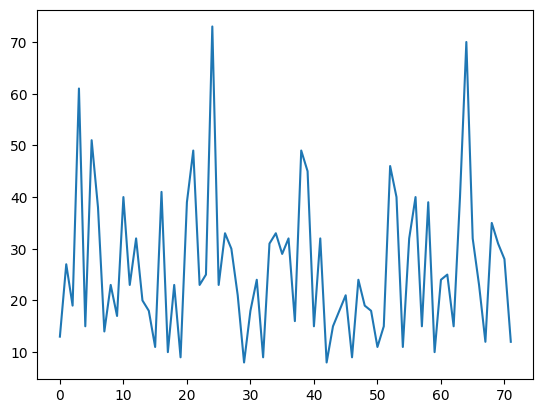

In [21]:
plt.plot(sarsa.episode_rewards)

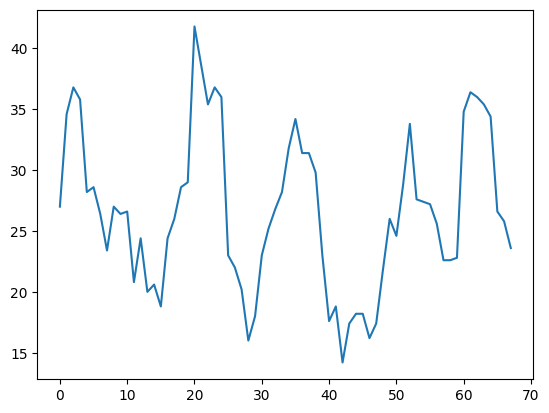

In [22]:
n = 5
ma = np.convolve(sarsa.episode_rewards, np.ones(n) / n, 'valid')
plt.plot(ma)

In [ ]:
import pickle

with open('sarsa_400r_30000s.pickle', 'wb') as f:
    pickle.dump(sarsa, f)

In [ ]:
# min_obs, max_obs

(array([-2.4097164 , -3.0748265 , -0.25516647, -2.9667487 ], dtype=float32),
 array([2.4484854 , 3.2317376 , 0.25910497, 3.0691397 ], dtype=float32))

### Q-Learning

In [ ]:
q_learning = QLearning(state_space_bounds, state_space_epsilon, action_space, alpha=0.5, gamma=0.95, greedey_epsilon=0.1)

In [ ]:
q_learning.greedy_epsilon = 0.0

In [ ]:
env = gym.make("CartPole-v1", render_mode="rgb_array")
observation, info = env.reset()

reward = None

# min_obs = observation
# max_obs = observation

for _ in range(1000000):
    action = q_learning.step(observation, reward)[0]
    observation, reward, terminated, truncated, info = env.step(action)

    # min_obs = np.min(np.array([observation, min_obs]), axis=0)
    # max_obs = np.max(np.array([observation, max_obs]), axis=0)

    if terminated or truncated:
        observation, info = env.reset()
        q_learning.reset_episode()
        reward = None

q_learning.reset_episode(False)
env.close()

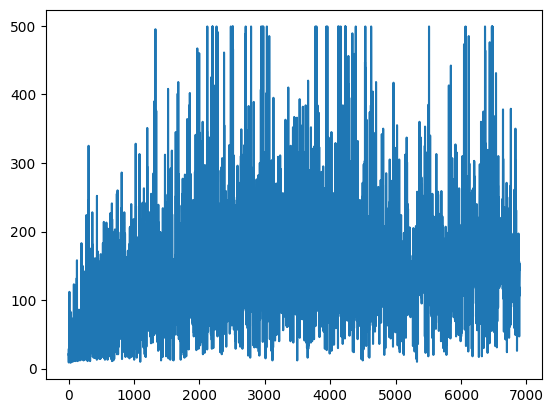

In [ ]:
plt.plot(q_learning.episode_rewards)

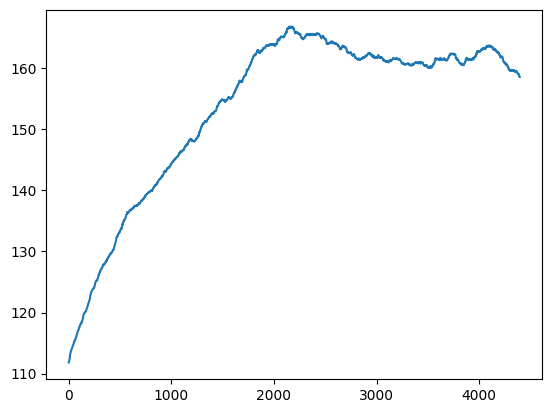

In [ ]:
n = 2500
ma = np.convolve(q_learning.episode_rewards, np.ones(n) / n, 'valid')
plt.plot(ma)

### Sarsa-AGDS

In [5]:
associata.init()

Got message: b'"started"'
Subprocess "vis" started successfully
Got message: b'"started"'
Subprocess "backend" started successfully


In [4]:
sarsa_agds = SarsaAGDS(state_space_feature_names, state_space_bounds, state_space_epsilon, action_space)

In [5]:
env = gym.make("CartPole-v1", render_mode="rgb_array")
observation, info = env.reset(seed=42)

reward = None

for _ in range(10):
    action = sarsa_agds.step(observation, reward)[0]
    observation, reward, terminated, truncated, info = env.step(action)

    if terminated or truncated:
        observation, info = env.reset()
        sarsa_agds.reset_episode()
        reward = None

sarsa_agds.reset_episode(False)
env.close()


=============== Step 0 ===============
[6s] Picked action: [1]

=============== Step 1 ===============
[6s] Picked action: [1]
Adding observation: {add_observation,#{"x_pos" => 0.02739560417830944, "x_speed" => -0.006112155970185995, "ang_pos" => 0.03585979342460632, "ang_speed" => 0.019736802205443382, "value" => 0.2, "action" => 1}}.

=============== Step 2 ===============
[6s] Picked action: [1]
Adding observation: {add_observation,#{"x_pos" => 0.02727336250245571, "x_speed" => 0.18847766518592834, "ang_pos" => 0.036254528909921646, "ang_speed" => -0.26141977310180664, "value" => 0.4, "action" => 1}}.

=============== Step 3 ===============
[6s] Picked action: [1]
Adding observation: {add_observation,#{"x_pos" => 0.0310429148375988, "x_speed" => 0.3830638527870178, "ang_pos" => 0.03102613240480423, "ang_speed" => -0.5424507260322571, "value" => 0.4, "action" => 1}}.

=============== Step 4 ===============
[6s] Picked action: [1]
Adding observation: {add_observation,#{"x_pos" => 0.0

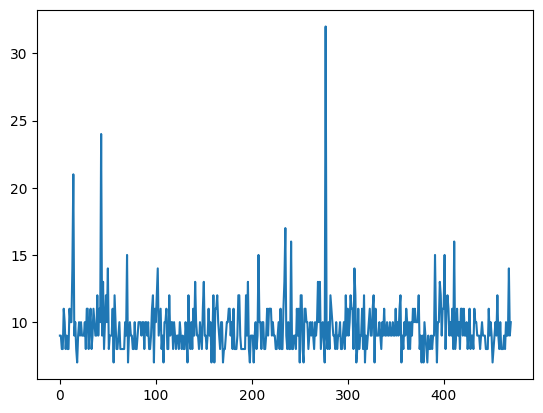

In [12]:
plt.plot(sarsa_agds.episode_rewards)

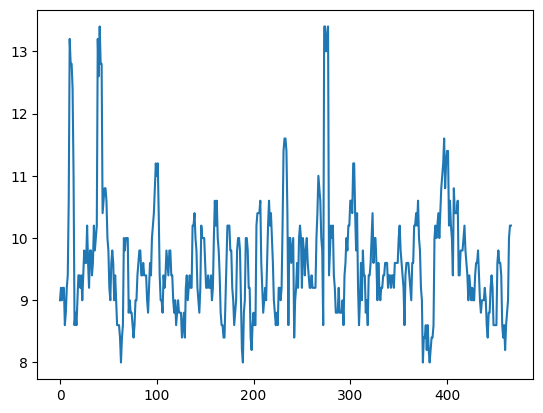

In [13]:
n = 5
ma = np.convolve(sarsa_agds.episode_rewards, np.ones(n) / n, 'valid')
plt.plot(ma)

In [6]:
sarsa_agds.stop()

Got message: b'"structure_stopped"'
Got message: b'"vis_stopped"'


In [6]:
associata.stop()

Subprocess "backend" stopped successfully
Subprocess "vis" stopped successfully


### Q-Learning AGDS

In [11]:
associata.init()

Got message: b'"started"'
Subprocess "vis" started successfully
Got message: b'"started"'
Subprocess "backend" started successfully


In [12]:
q_learning_agds = QLearningAGDS(state_space_feature_names, state_space_bounds, state_space_epsilon, action_space)

In [13]:
env = gym.make("CartPole-v1", render_mode="human")
observation, info = env.reset(seed=42)

reward = None

for _ in range(200):
    action = q_learning_agds.step(observation, reward)[0]
    observation, reward, terminated, truncated, info = env.step(action)

    if terminated or truncated:
        observation, info = env.reset()
        q_learning_agds.reset_episode()
        reward = None

q_learning_agds.reset_episode(False)
env.close()


=============== Step 0 ===============
[2s] Picked action: [0]

=============== Step 1 ===============
[2s] Picked action: [0]
Adding observation: {add_observation,#{"x_pos" => 0.02739560417830944, "x_speed" => -0.006112155970185995, "ang_pos" => 0.03585979342460632, "ang_speed" => 0.019736802205443382, "value" => 0.2, "action" => 0}}.

=============== Step 2 ===============
[2s] Picked action: [0]
Adding observation: {add_observation,#{"x_pos" => 0.02727336250245571, "x_speed" => -0.20172953605651855, "ang_pos" => 0.036254528909921646, "ang_speed" => 0.32351475954055786, "value" => 0.4, "action" => 0}}.

=============== Step 3 ===============
[2s] Picked action: [0]
Adding observation: {add_observation,#{"x_pos" => 0.02323877066373825, "x_speed" => -0.39734846353530884, "ang_pos" => 0.04272482171654701, "ang_speed" => 0.6274068355560303, "value" => 0.56, "action" => 0}}.

=============== Step 4 ===============
[3s] Picked action: [0]
Adding observation: {add_observation,#{"x_pos" => 

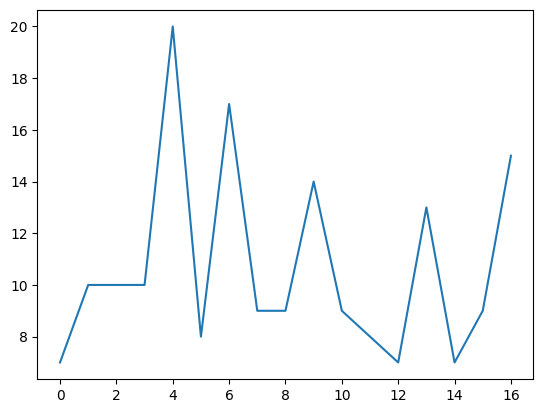

In [14]:
plt.plot(q_learning_agds.episode_rewards)

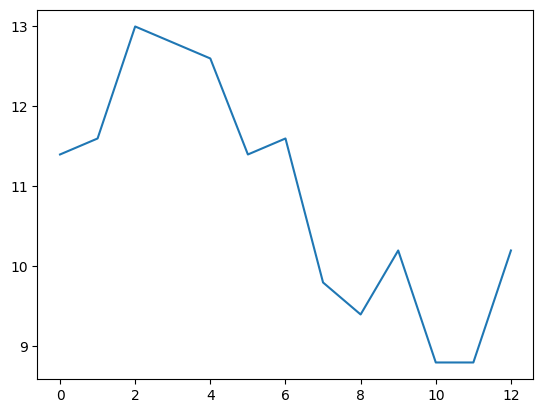

In [15]:
n = 5
ma = np.convolve(q_learning_agds.episode_rewards, np.ones(n) / n, 'valid')
plt.plot(ma)

In [16]:
q_learning_agds.stop()

Got message: b'"structure_stopped"'
Got message: b'"vis_stopped"'


In [17]:
associata.stop()

Subprocess "backend" stopped successfully
Subprocess "vis" stopped successfully
